# ML Project

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.dummy import DummyClassifier
import random
import metoder
import pandas as pd




Importing dataset:

In [2]:
#path:
#file_path = r"C:\Users\vikto\Documents\Skole\Datadrevne_systemer\ML_Project\glass_data-4_lev.csv"
file_path = "Dataset/modified_data.csv"
#importing file and print how the structure of data were inported. 
df = pd.read_csv(file_path)
df.drop(columns=['odor'], inplace=True)
df.drop(columns=['bruises'], inplace=True)

# Define a mapping dictionary
#type_mapping = {'T1': 0, 'T2': 1, 'T3': 2, 'T4': 3, 'T5': 4, 'T6': 5}

# Apply the mapping to the 'Type' column
#df['Type'] = df['Type'].map(type_mapping)

#drop ID number
#df = df.drop(columns=['Id'])

# Verify the 'Type' column is now of type int64
print(df['class'].dtype)
df.info()

object
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   class           300 non-null    object
 1   capShape        300 non-null    object
 2   capSurface      300 non-null    object
 3   capColor        300 non-null    object
 4   gillAttachment  300 non-null    object
 5   gillSpacing     300 non-null    object
 6   gillSize        300 non-null    object
dtypes: object(7)
memory usage: 16.5+ KB


### Small exploration of data:

The data set clearly shows that T1, T2 is most frequently. 

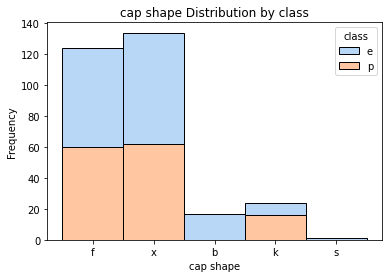

In [3]:
# Create a histogram of age with hue for income
sns.histplot(data=df, x='capShape', hue='class', multiple='stack', palette='pastel')

# Add labels and title
plt.xlabel('cap shape')
plt.ylabel('Frequency')
plt.title('cap shape Distribution by class')

# Show the plot
plt.show()

In [4]:
#for col in df.columns[:-1]:  # Exclude the 'Type' column
 #   sns.boxplot(x='Type', y=col, data=df)
  #  plt.show()

One-hot encoding to ensure the best result

In [6]:
import pandas as pd

# Perform one-hot encoding for all categorical columns except the "class" column
df_encoded = pd.get_dummies(df, columns=["capShape", "capSurface", "capColor", "gillAttachment", "gillSpacing", "gillSize"])

# You can also encode the target variable "class" if needed
# class_encoded = pd.get_dummies(df["class"], prefix="class")

# Replace "p" with 1 and "e" with 0 in the "class" column in the df_encoded DataFrame
df_encoded['class'] = df_encoded['class'].apply(lambda x: 1 if x == 'p' else 0)

# Convert the "class" column to a numeric data type (int)
#df_encoded['class'] = pd.to_numeric(df['class'])

# Print the resulting DataFrame
print(df_encoded)


     class  capShape_b  capShape_f  capShape_k  capShape_s  capShape_x  \
0        0           0           1           0           0           0   
1        1           0           0           0           0           1   
2        0           0           0           0           0           1   
3        0           1           0           0           0           0   
4        0           0           1           0           0           0   
..     ...         ...         ...         ...         ...         ...   
295      0           0           0           0           0           1   
296      0           0           0           0           0           1   
297      1           0           0           0           0           1   
298      1           0           0           0           0           1   
299      0           0           0           0           0           1   

     capSurface_f  capSurface_s  capSurface_y  capColor_b  ...  capColor_p  \
0               0             0  

### Make a neural network:

Split data to training and validation and Scale the data: 

In [7]:
# Prepare the Data for training:
X = df_encoded.drop(columns=['class']).values  # Features (excluding 'Type' column)
y = df_encoded['class'].values  # Labels

# Split Data into Training and Validation Sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the Data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
print(type(X_train[0][0]))

<class 'numpy.float64'>


Create pytorch model:

In [ ]:

# Convert numpy arrays to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.long)

# Create DataLoader for training and validation sets
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=7, shuffle=True)
val_dataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=7)

# Build the Neural Network
class GlassClassifier(nn.Module):
    def __init__(self):
        super(GlassClassifier, self).__init__()
        self.fc1 = nn.Linear(9, 64)
        self.fc2 = nn.Linear(64, 90)
        self.fc3 = nn.Linear(90, 64)
        self.fc4 = nn.Linear(64, 6)  # 6 output units for 6 types
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

model = GlassClassifier()

# Step 5: Define Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Step 6: Train the Model
# Define a list to store training losses
train_losses = []

# Define the number of epochs
num_epochs = 200

# Train the model and track the training loss
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    # Calculate average loss for the epoch
    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)

# Plot the training loss
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

Evaluate model:

In [ ]:
# Step 7: Evaluate the Model
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.numpy())
        all_labels.extend(labels.numpy())

# Generate the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[f'T{i}' for i in range(1, 8)],
            yticklabels=[f'T{i}' for i in range(1, 8)])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

correct = sum(pred == label for pred, label in zip(all_preds, all_labels))
accuracy = correct / len(all_labels)
#print()
print(f'Validation Accuracy: {accuracy * 100:.2f}%')

In [8]:
rf = metoder.randomforest(df_encoded)

In [9]:
gb = metoder.gradientboost(df_encoded)

In [10]:
lr = metoder.linearregression(df_encoded)

In [11]:
dr = metoder.decisionregressor(df_encoded)

In [12]:
mlp = metoder.mlpregression(df_encoded)

In [13]:
svr = metoder.supportvectoregressor(df_encoded)

In [14]:
KNN = metoder.kneighborsregressor(df_encoded)

In [15]:
models = ['KNN Regressor', 'Linear Regression', 'Decision Tree Regressor' ,'Random Forest Regressor',
 'Gradient Boosting Regressor','Support Vector Regressor', 'MLP Regressor']
tests_score = [KNN, lr, dr, rf, gb, svr, mlp]
compare_models = pd.DataFrame({ "Algorithms": models, "Tests Score": tests_score })
compare_models.sort_values(by = "Tests Score", ascending = False)

,Algorithms,Tests Score
3,Random Forest Regressor,0.866667
4,Gradient Boosting Regressor,0.850000
2,Decision Tree Regressor,0.789407
6,MLP Regressor,0.773683
5,Support Vector Regressor,0.687181
0,KNN Regressor,0.667740
1,Linear Regression,0.554474


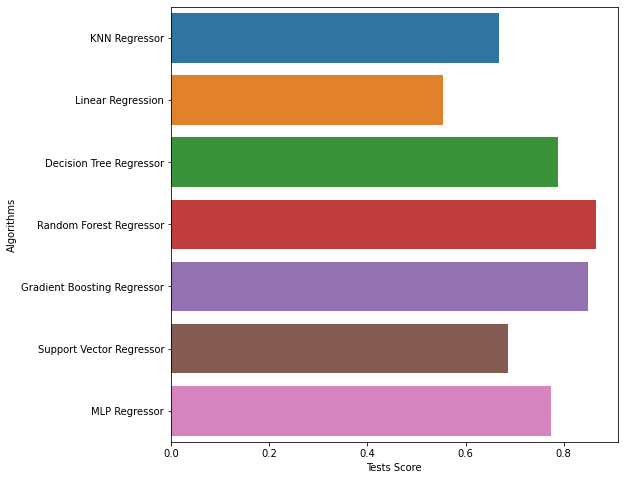

In [16]:
%matplotlib inline
plt.figure(figsize=(8,8))
sns.barplot(x = "Tests Score", y = "Algorithms", data = compare_models)
plt.show()